In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# 获取dash币数据，从2016至今
dashcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/dash/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
dashcoin_market_info = dashcoin_market_info.assign(Date=pd.to_datetime(dashcoin_market_info['Date']))

dashcoin_market_info['Volume'] = dashcoin_market_info['Volume'].astype('int64')
# look at the first few rows
dashcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-03-29,350.85,351.36,317.97,329.28,101243000,2797320000
1,2018-03-28,354.94,368.51,348.56,351.26,107592000,2829260000
2,2018-03-27,390.24,392.19,354.23,354.75,88373400,3109950000
3,2018-03-26,410.73,413.66,372.97,390.87,107776000,3272470000
4,2018-03-25,420.01,423.19,409.39,411.79,102753000,3345720000


In [2]:
dashcoin_market_info.tail()

,Date,Open,High,Low,Close,Volume,Market Cap
1500,2014-02-18,1.180000,1.500000,0.841751,1.040000,160779,3960320
1501,2014-02-17,0.406039,1.500000,0.402588,1.450000,178618,1360260
1502,2014-02-16,0.325840,0.459833,0.310345,0.406976,28017,1085280
1503,2014-02-15,0.331111,0.354461,0.219434,0.314865,21119,1092120
1504,2014-02-14,0.213899,0.378883,0.213899,0.374024,15422,702537


In [3]:
dashcoin_market_info.columns =[dashcoin_market_info.columns[0]]+['dash_'+i for i in dashcoin_market_info.columns[1:]]

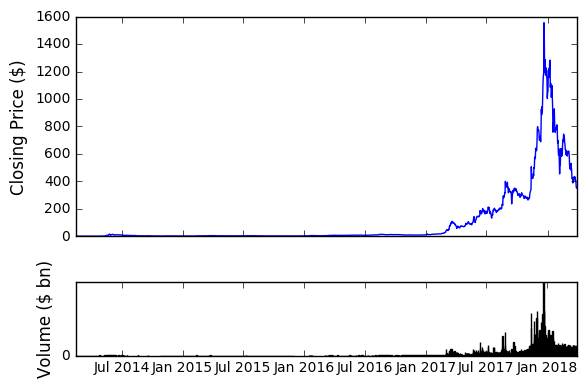

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(dashcoin_market_info['Date'].astype(datetime.datetime),dashcoin_market_info['dash_Open'])
ax2.bar(dashcoin_market_info['Date'].astype(datetime.datetime).values, dashcoin_market_info['dash_Volume'].values)
fig.tight_layout()
plt.show()

In [5]:
dashcoin_market_info=dashcoin_market_info[dashcoin_market_info['Date']>='2016-01-01']
kwargs = { 'dash_day_diff': lambda x: (x['dash_Close']-x['dash_Open'])/x['dash_Open']}
dashcoin_info = dashcoin_market_info.assign(**kwargs)
dashcoin_info.head()


,Date,dash_Open,dash_High,dash_Low,dash_Close,dash_Volume,dash_Market Cap,dash_day_diff
0,2018-03-29,350.85,351.36,317.97,329.28,101243000,2797320000,-0.061479
1,2018-03-28,354.94,368.51,348.56,351.26,107592000,2829260000,-0.010368
2,2018-03-27,390.24,392.19,354.23,354.75,88373400,3109950000,-0.090944
3,2018-03-26,410.73,413.66,372.97,390.87,107776000,3272470000,-0.048353
4,2018-03-25,420.01,423.19,409.39,411.79,102753000,3345720000,-0.019571


In [8]:
# build LSTM

In [6]:
kwargs = { 'dash_close_off_high': lambda x: 2*(x['dash_High']- x['dash_Close'])/(x['dash_High']-x['dash_Low'])-1,
            'dash_volatility': lambda x: (x['dash_High']- x['dash_Low'])/(x['dash_Open'])}
dashcoin_info = dashcoin_info.assign(**kwargs)


In [7]:
model_data = dashcoin_info[['Date']+['dash_'+metric  
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()


,Date,dash_Close,dash_Volume,dash_close_off_high,dash_volatility
818,2016-01-01,3.38,98317,6.666667e-02,0.090090
817,2016-01-02,3.28,62353,5.789474e-01,0.056213
816,2016-01-03,3.24,87155,-1.998401e-15,0.066869
815,2016-01-04,3.32,65748,-4.545455e-01,0.033846
814,2016-01-05,3.33,71861,4.666667e-01,0.045181


In [8]:
# we don't need the date columns anymore
split_date = '2017-06-01'
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [9]:
window_len = 10
norm_cols = ['dash_'+metric for metric in ['Close','Volume']]

In [10]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['dash_Close'][window_len:].values/training_set['dash_Close'][:-window_len].values)-1

In [11]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['dash_Close'][window_len:].values/test_set['dash_Close'][:-window_len].values)-1

In [12]:
LSTM_training_inputs[0]

,dash_Close,dash_Volume,dash_close_off_high,dash_volatility
818,0.000000,0.000000,6.666667e-02,0.090090
817,-0.029586,-0.365796,5.789474e-01,0.056213
816,-0.041420,-0.113531,-1.998401e-15,0.066869
815,-0.017751,-0.331265,-4.545455e-01,0.033846
814,-0.014793,-0.269089,4.666667e-01,0.045181
813,0.000000,-0.648667,-6.363636e-01,0.033033
812,0.000000,0.183651,3.108624e-15,0.041543
811,-0.020710,-0.219809,3.750000e-01,0.046921
810,-0.059172,-0.601554,1.000000e+00,0.057576
809,-0.026627,0.705483,-1.000000e+00,0.144654


In [13]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [14]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

Using TensorFlow backend.


In [15]:
# random seed for reproducibility
np.random.seed(10)
# initialise model architecture
dash_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
dash_history = dash_model.fit(LSTM_training_inputs, 
                            (training_set['dash_Close'][window_len:].values/training_set['dash_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #dash_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 10s - loss: 0.1183
Epoch 2/50
 - 7s - loss: 0.0768
Epoch 3/50
 - 7s - loss: 0.0725
Epoch 4/50
 - 7s - loss: 0.0646
Epoch 5/50
 - 7s - loss: 0.0618
Epoch 6/50
 - 7s - loss: 0.0573
Epoch 7/50
 - 7s - loss: 0.0584
Epoch 8/50
 - 7s - loss: 0.0583
Epoch 9/50
 - 7s - loss: 0.0572
Epoch 10/50
 - 7s - loss: 0.0545
Epoch 11/50
 - 7s - loss: 0.0565
Epoch 12/50
 - 7s - loss: 0.0537
Epoch 13/50
 - 7s - loss: 0.0542
Epoch 14/50
 - 7s - loss: 0.0528
Epoch 15/50
 - 7s - loss: 0.0517
Epoch 16/50
 - 7s - loss: 0.0515
Epoch 17/50
 - 7s - loss: 0.0509
Epoch 18/50
 - 7s - loss: 0.0512
Epoch 19/50
 - 7s - loss: 0.0525
Epoch 20/50
 - 8s - loss: 0.0520
Epoch 21/50
 - 7s - loss: 0.0485
Epoch 22/50
 - 7s - loss: 0.0528
Epoch 23/50
 - 7s - loss: 0.0494
Epoch 24/50
 - 8s - loss: 0.0521
Epoch 25/50
 - 7s - loss: 0.0491
Epoch 26/50
 - 7s - loss: 0.0488
Epoch 27/50
 - 7s - loss: 0.0480
Epoch 28/50
 - 7s - loss: 0.0507
Epoch 29/50
 - 7s - loss: 0.0509
Epoch 30/50
 - 7s - loss: 0.0524
Epoch 31/50
 - 7s 

In [ ]:
# We can also build a similar LSTM model for dashcoin- test set predictions are plotted below

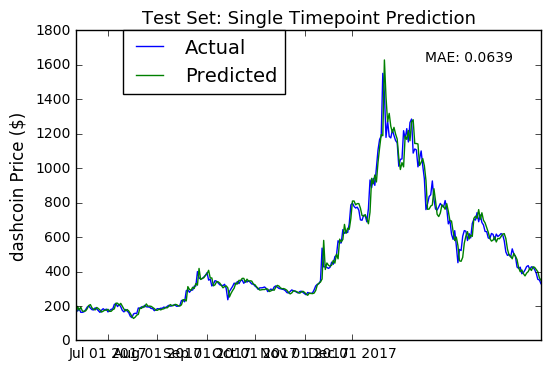

In [17]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['dash_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(dash_model.predict(LSTM_test_inputs))+1) * test_set['dash_Close'].values[:-window_len])[0], 
         label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(dash_model.predict(LSTM_test_inputs))+1)-\
            (test_set['dash_Close'].values[window_len:])/(test_set['dash_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('dashcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [ ]:
# We'll now build LSTM models to predict crypto DASH prices for the next 5 days.

In [18]:
# for DASH coin

# random seed for reproducibility
np.random.seed(10)
# we'll try to predict the closing price for the next 5 days 
pred_range = 5

# initialise model architecture
dash_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['dash_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['dash_Close'][i:i+pred_range].values/
                                  training_set['dash_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data

dash_history = dash_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 8s - loss: 0.1437
Epoch 2/50
 - 7s - loss: 0.1054
Epoch 3/50
 - 7s - loss: 0.0962
Epoch 4/50
 - 7s - loss: 0.0903
Epoch 5/50
 - 7s - loss: 0.0931
Epoch 6/50
 - 7s - loss: 0.0894
Epoch 7/50
 - 7s - loss: 0.0895
Epoch 8/50
 - 7s - loss: 0.0874
Epoch 9/50
 - 7s - loss: 0.0864
Epoch 10/50
 - 7s - loss: 0.0859
Epoch 11/50
 - 7s - loss: 0.0827
Epoch 12/50
 - 7s - loss: 0.0854
Epoch 13/50
 - 7s - loss: 0.0845
Epoch 14/50
 - 7s - loss: 0.0832
Epoch 15/50
 - 7s - loss: 0.0833
Epoch 16/50
 - 7s - loss: 0.0836
Epoch 17/50
 - 7s - loss: 0.0816
Epoch 18/50
 - 7s - loss: 0.0818
Epoch 19/50
 - 7s - loss: 0.0825
Epoch 20/50
 - 7s - loss: 0.0812
Epoch 21/50
 - 7s - loss: 0.0799
Epoch 22/50
 - 7s - loss: 0.0822
Epoch 23/50
 - 7s - loss: 0.0804
Epoch 24/50
 - 7s - loss: 0.0802
Epoch 25/50
 - 7s - loss: 0.0812
Epoch 26/50
 - 7s - loss: 0.0808
Epoch 27/50
 - 7s - loss: 0.0834
Epoch 28/50
 - 7s - loss: 0.0795
Epoch 29/50
 - 7s - loss: 0.0818
Epoch 30/50
 - 7s - loss: 0.0803
Epoch 31/50
 - 7s -

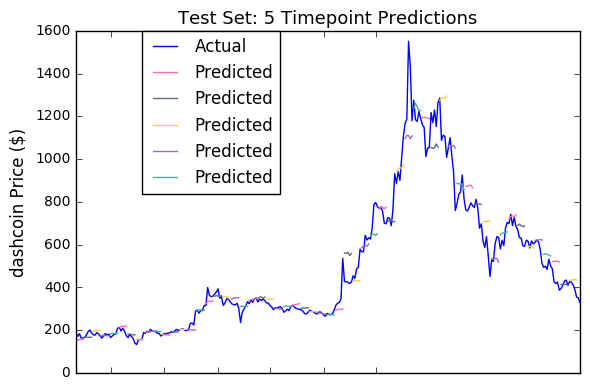

In [21]:
# predict and visualize
dash_pred_prices = ((dash_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['dash_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['dash_Close'][window_len:], label='Actual')


for i, dash_pred in enumerate(dash_pred_prices):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 dash_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 dash_pred, color=pred_colors[i%5])
    
    
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('dashcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')

ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()